In [3]:
import numpy as np
import sys
sys.path.append('../')
import heartbeat as hb
import matplotlib.pyplot as plt

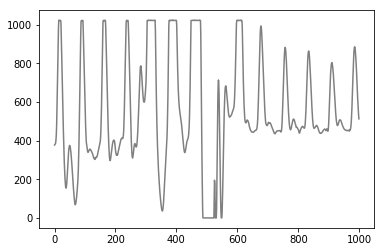

In [4]:
data = hb.get_data('clipping_part.csv')
plt.plot(data, color='grey')
plt.show()

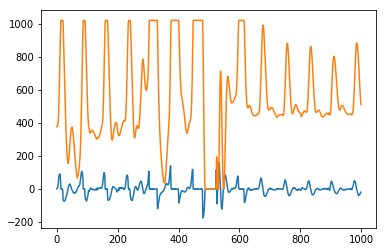

In [5]:
slopes = np.diff(data)
plt.plot(slopes)
plt.plot(data)
plt.show()

In [6]:
clip_binary = np.where(data > 1020)
print(clip_binary)



(array([ 14,  15,  16,  17,  18,  19,  20,  88,  89,  90,  91,  92,  93,
       160, 161, 162, 163, 164, 165, 166, 167, 236, 237, 238, 239, 240,
       241, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315,
       316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328,
       329, 330, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386,
       387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399,
       400, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459,
       460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472,
       473, 474, 475, 476, 477, 478, 479, 598, 599, 600, 601, 602, 603,
       604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615], dtype=int64),)


In [7]:
clipping_edges = np.where(np.diff(clip_binary) > 1)[1]
print(clipping_edges)

[  6  12  20  26  53  78 110]


In [8]:
clipping_segments = []

for i in range(0, len(clipping_edges)):
    print("%s,%s" %(i, clipping_edges[i]))
    if i == 0: #if first clipping segment
        clipping_segments.append((clip_binary[0][0], 
                                clip_binary[0][clipping_edges[0]]))
    else:
        clipping_segments.append((clip_binary[0][clipping_edges[i-1] + 1],
                               clip_binary[0][clipping_edges[i]]))

#append last entry
clipping_segments.append((clip_binary[0][clipping_edges[i]+1],
                       clip_binary[0][-1]))    

print(clipping_segments)

0,6
1,12
2,20
3,26
4,53
5,78
6,110
[(14, 20), (88, 93), (160, 167), (236, 241), (304, 330), (376, 400), (448, 479), (598, 615)]


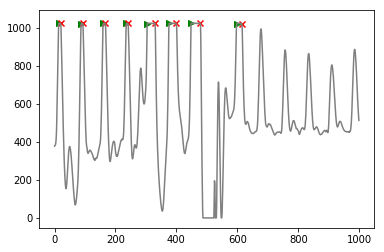

In [9]:
clip_starts = [x[0] for x in clipping_segments]
clip_ends = [x[1] for x in clipping_segments]

plt.plot(data, color='grey')
plt.scatter(clip_starts, [data[x] for x in clip_starts], color='green', marker='>')
plt.scatter(clip_ends, [data[x] for x in clip_ends], color='red', marker='x')
plt.show()

In [10]:
def mark_clipping(data, threshold=1020):
    '''function that marks start and end of clipping part
    it detects the start and end of clipping segments and returns them
    
    keyword arguments:
    - data: 1d list or numpy array containing heart rate data
    - threshold: the threshold for clipping, recommended to
    be a few data points below ADC or sensor max value, to
    compensate for signal noise (default 1020)
    
    '''
    clip_binary = np.where(data > threshold)
    clipping_edges = np.where(np.diff(clip_binary) > 1)[1]

    clipping_segments = []

    for i in range(0, len(clipping_edges)):
        if i == 0: #if first clipping segment
            clipping_segments.append((clip_binary[0][0], 
                                    clip_binary[0][clipping_edges[0]]))
        else:
            clipping_segments.append((clip_binary[0][clipping_edges[i-1] + 1],
                                   clip_binary[0][clipping_edges[i]]))

    #append last entry
    clipping_segments.append((clip_binary[0][clipping_edges[i]+1],
                           clip_binary[0][-1]))    

    return clipping_segments

In [11]:
clipping_segments = mark_clipping(data)

print(clipping_segments)

[(14, 20), (88, 93), (160, 167), (236, 241), (304, 330), (376, 400), (448, 479), (598, 615)]


In [12]:
from scipy.interpolate import UnivariateSpline

In [13]:
def interpolate_hrdata(data, clipping_segments, sampling_rate):
    '''function that interpolates peaks between
    the clipping segments using cubic spline interpolation.
    
    It takes the clipping start +/- 100ms to calculate the spline
    
    keyword arguments:
    data - 1d list or numpy array containing heart rate data
    clipping_segments - list containing tuples of start- and 
    end-points of clipping segments.
    '''
    
    num_datapoints = int(0.1 * sampling_rate)
    
    newx = []
    newy = []
    
    for segment in clipping_segments:
        antecedent = data[segment[0] - num_datapoints : segment[0]]
        consequent = data[segment[1] : segment[1] + num_datapoints]
        segment_data = np.concatenate((antecedent, consequent))
        
        interpdata_x = np.concatenate(([x for x in range(segment[0] - num_datapoints, segment[0])],
                                 [x for x in range(segment[1], segment[1] + num_datapoints)]))

        
        x_new = np.linspace(segment[0] - num_datapoints,
                                  segment[1] + num_datapoints,
                                  ((segment[1] - segment[0]) + (2 * num_datapoints)))
        
        
        
        interp_func = UnivariateSpline(interpdata_x, segment_data, k=3)
        
        plt.figure(figsize=(4,2))
        plt.subplot(121)
        plt.plot([x for x in range(segment[0]-10, segment[1]+10)], data[segment[0]-10:segment[1]+10])
        plt.subplot(122)
        plt.plot(x_new, interp_func(x_new))
        plt.tight_layout()
        plt.show()
        
        newx.append([x for x in x_new])
        newy.append([x for x in interp_func(x_new)])
        
    return newx, newy
    

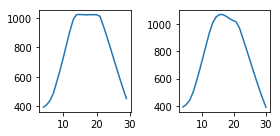

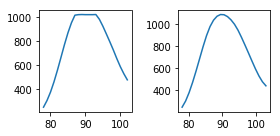

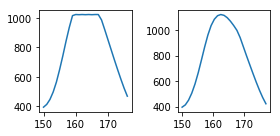

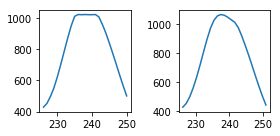

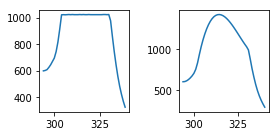

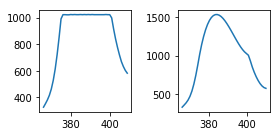

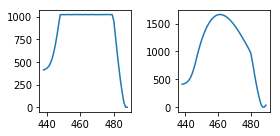

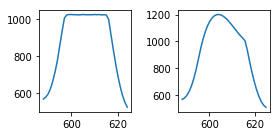

In [14]:
newx, newy = interpolate_hrdata(data, clipping_segments, 100.0)

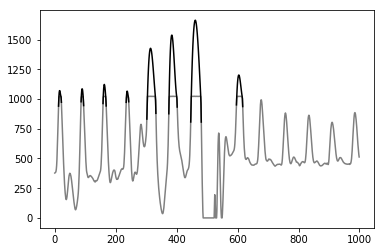

In [15]:
plt.plot(data, color='grey')
for x,y in zip(newx, newy):
    plt.plot(x[8:-8],y[8:-8], color='black')

plt.show()

In [ ]:
def mark_clipping(data, threshold=1020):
    '''function that marks start and end of clipping part
    it detects the start and end of clipping segments and returns them
    
    keyword arguments:
    - data: 1d list or numpy array containing heart rate data
    - threshold: the threshold for clipping, recommended to
    be a few data points below ADC or sensor max value, to
    compensate for signal noise (default 1020)
    '''
    
    clip_binary = np.where(data > threshold)
    clipping_edges = np.where(np.diff(clip_binary) > 1)[1]

    clipping_segments = []

    for i in range(0, len(clipping_edges)):
        if i == 0: #if first clipping segment
            clipping_segments.append((clip_binary[0][0], 
                                    clip_binary[0][clipping_edges[0]]))
        else:
            clipping_segments.append((clip_binary[0][clipping_edges[i-1] + 1],
                                   clip_binary[0][clipping_edges[i]]))

    #append last entry
    clipping_segments.append((clip_binary[0][clipping_edges[i]+1],
                           clip_binary[0][-1]))    

    return clipping_segments

def interpolate_peak(data, clipping_segments, sampling_rate):
    '''function that interpolates peak between
    the clipping segments using cubic spline interpolation.
    
    It takes the clipping start +/- 100ms to calculate the spline
    
    keyword arguments:
    data - 1d list or numpy array containing heart rate data
    clipping_segment - list containing tuples of start- and 
    end-points of clipping segments.
    '''
    
    num_datapoints = int(0.1 * sampling_rate)
    newx = []
    newy = []
    
    for segment in clipping_segments:
        antecedent = data[segment[0] - num_datapoints : segment[0]]
        consequent = data[segment[1] : segment[1] + num_datapoints]
        segment_data = np.concatenate((antecedent, consequent))
        
        interpdata_x = np.concatenate(([x for x in range(segment[0] - num_datapoints, segment[0])],
                                 [x for x in range(segment[1], segment[1] + num_datapoints)]))
        x_new = np.linspace(segment[0] - num_datapoints,
                                  segment[1] + num_datapoints,
                                  ((segment[1] - segment[0]) + (2 * num_datapoints)))
        
        interp_func = UnivariateSpline(interpdata_x, segment_data, k=3)
        interp_data = interp_func(x_new)
        R-peak = 
        
    return newx, newy

In [ ]:
interpolate_peaks(data, clipping_segments, 100):